## Evaluation des Modells

Es gibt verschiedene Wege Klassifikatoren zu evaluieren.

Traditionelle Evluationsmetriken umfassen
* Accurary
* Precision
* Recall
* F1-Score

Im folgenden wird das Modell hinsichtlich weiterer Aspekte evaluiert
* Quantifizierung von Unsicherheit
* Erklärung einzelner Modellprognosen 
* Aufdecken gelernter Zusammenhänge

In [14]:
#from skrebate import ReliefF
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import csv
import shap

#from sklearn.metrics import matthews_corrcoef
#from scipy.stats import spearmanr
#from scipy.stats import pearsonr
#from scipy.stats import chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import category_encoders as ce
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go

In [13]:
def get_prob_matrix(model, x_test, n_estimators, laplace_smoothing, log=False):
    porb_matrix = [[[] for j in range(n_estimators)] for i in range(x_test.shape[0])]
    for etree in range(n_estimators):
        # populate the porb_matrix with the tree_prob
        tree_prob = model.estimators_[etree].predict_proba(x_test)
        if laplace_smoothing > 0:
            leaf_index_array = model.estimators_[etree].apply(x_test)
            for data_index, leaf_index in enumerate(leaf_index_array):
                leaf_values = model.estimators_[etree].tree_.value[leaf_index]
                leaf_samples = np.array(leaf_values).sum()
                for i,v in enumerate(leaf_values[0]):
                    tmp = (v + laplace_smoothing) / (leaf_samples + (len(leaf_values[0]) * laplace_smoothing))
                    tree_prob[data_index][i] = (v + laplace_smoothing) / (leaf_samples + (len(leaf_values[0]) * laplace_smoothing))

        for data_index, data_prob in enumerate(tree_prob):
            porb_matrix[data_index][etree] = list(data_prob)

        if log:
            print(f"----------------------------------------[{etree}]")
            print(f"class {model.estimators_[etree].predict(x_test)}  prob \n{tree_prob}")
    return porb_matrix

def uncertainty_estimate(probs): # three dimentianl array with d1 as datapoints, (d2) the rows as samples and (d3) the columns as probability for each class
    p = np.array(probs)
    entropy = -p*np.ma.log10(p)
    entropy = entropy.filled(0)
    a = np.sum(entropy, axis=1)
    a = np.sum(a, axis=1) / entropy.shape[1]
    p_m = np.mean(p, axis=1)
    total = -np.sum(p_m*np.ma.log10(p_m), axis=1)
    total = total.filled(0)
    e = total - a
    return total, e, a

# Train Model 

In [15]:
df = pd.read_hdf('preprocessed_data.h5', 'df')
x_train = pd.read_hdf('preprocessed_data.h5', 'x_train')
x_test = pd.read_hdf('preprocessed_data.h5', 'x_test')
y_train = pd.read_hdf('preprocessed_data.h5', 'y_train')
y_test = pd.read_hdf('preprocessed_data.h5', 'y_test')

In [16]:
metric_features = ['QUOTE_PRICE_ASK', 'SPREAD', 'COUPON', 'MATURITY_REMAINING', 'QUANTITY1', 'MID', 'PRICE','INTERBANK_POINTS','SALES_FEE']

ordinal_features=['BOND_RATING_MOODYS','COMPETITION_COUNT']

categorical_features =  ['CUSTOMER_USER', 'CUSTOMER_USER_ID', 'CUSTOMER_COMPANY', 'CUSTOMER_COMPANY_ID', 'CUSTOMER_GROUP','CUSTOMER_CLASSIFICATION',
                       'INSTRUMENT_IDENTIFIER', 'INSTRUMENT_GROUP_ID', 'INSTRUMENT_BOOK', 'MARKET_NAME','NOTIONAL_CURRENCY', 'SALES_GROUP', 'SALES_USER', 
                       'SECTOR','CUSTOMER_SUBACCOUNT_ID', 'CUSTOMER_COUNTRY', 'POPUP_REASON_EXISTS']

binary_features = ['POPUP_QUOTE_REFLEX_STATUS', 'POPUP_QUOTE_SIZE_EXCEEDED','POPUP_LIMIT_EXCEEDED', 'AXE_WAS_ACTIVE', 'LIQUID', 'SI','IS_CONSULTANCY',]

y='TRADE'

to_remove = ['CUSTOMER_USER_AVERAGE_PRICE',
 'CUSTOMER_USER_AVERAGE_SPREAD',
 'CUSTOMER_USER_AVERAGE_TRADE_PRICE',
 'CUSTOMER_USER_AVERAGE_TRADE_SPREAD',
 'CUSTOMER_COMPANY_AVERAGE_PRICE',
 'CUSTOMER_COMPANY_AVERAGE_SPREAD',
 'CUSTOMER_COMPANY_AVERAGE_TRADE_PRICE',
 'CUSTOMER_COMPANY_AVERAGE_TRADE_SPREAD',
'CUSTOMER_CLASSIFICATION',
 'SALES_GROUP',
 'CUSTOMER_COUNTRY',
 'IS_CONSULTANCY',
'CUSTOMER_USER_ID',
 'CUSTOMER_COMPANY_ID',
 'CUSTOMER_COUNTRY',
 'INSTRUMENT_GROUP_ID',
 'POPUP_QUOTE_REFLEX_STATUS',
 'INSTRUMENT_IDENTIFIER',
 'POPUP_REASON_EXISTS',
 'CUSTOMER_COMPANY',
 'CUSTOMER_GROUP',
 'POPUP_LIMIT_EXCEEDED',
 'QUOTE_PRICE_ASK']

x_train.drop(to_remove, axis = 1, inplace=True)
x_test.drop(to_remove, axis = 1, inplace=True)

In [17]:
encoder = ce.CatBoostEncoder(cols=[x for x in (categorical_features+binary_features+ordinal_features) if x not in to_remove])
encoder.fit(x_train, y_train)
x_train_encoded = encoder.transform(x_train)
x_test_encoded = encoder.transform(x_test)

rf_criterion = 'entropy'
rf_max_depth = 5
rf_n_estimators = 10

model = RandomForestClassifier(bootstrap=True,
                                            criterion=rf_criterion,
                                            max_depth=rf_max_depth,
                                            n_estimators=rf_n_estimators,
                                            random_state=None,
                                            verbose=0,
                                            warm_start=False)

model.fit(x_train_encoded, y_train)
preds_proba = model.predict_proba(x_test_encoded) 
preds_class = model.predict(x_test_encoded) 

# Evaluation based on prediction Performance

In [92]:
accuracy = round(accuracy_score(y_test, preds_class),2)
precision = round(precision_score(y_test, preds_class),2)
recall = round(recall_score(y_test, preds_class),2)
f1 = round(f1_score(y_test, preds_class),2)

In [97]:
fig = go.Figure(data=[go.Table(header=dict(values=['Accuracy', 'Precision', 'Recall', 'F1']),
                 cells=dict(values=[accuracy,precision,recall,f1]))])
fig.write_image("Pictures/Model Evaluation.png")

# Evaluate Uncertainties

In [18]:
rf_laplace_smoothing = 1
prob_matrix = get_prob_matrix(model, x_test, rf_n_estimators, rf_laplace_smoothing, log=0)
total_uncertainty, epistemic_uncertainty, aleatoric_uncertainty = uncertainty_estimate(np.array(prob_matrix))
uncertainties = pd.DataFrame({'Total': total_uncertainty,'Epistemic': epistemic_uncertainty,'Aleatoric': aleatoric_uncertainty})

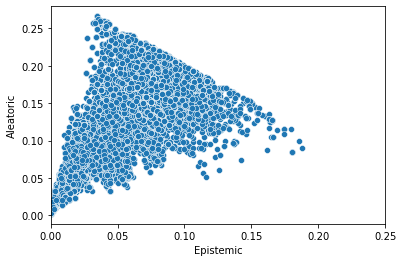

In [71]:
g = sns.scatterplot(data=uncertainties, x="Epistemic", y="Aleatoric")
plt.xlim(0, 0.25)
plt.savefig('Pictures/uncertainties_scatter.png')

In [26]:
total_mean, ep_mean, al_mean = uncertainties.mean()
print('Uncertainty Mean Values')
print(f'Total Uncertainty {total_mean}')
print(f'Epistemischer Anteil {ep_mean/total_mean}')
print(f'Aleatorischer Anteil {al_mean/total_mean}')

Uncertainty Mean Values
Total Uncertainty 0.13033768716874378
Epistemischer Anteil 0.34739331510824883
Aleatorischer Anteil 0.6526066848913609


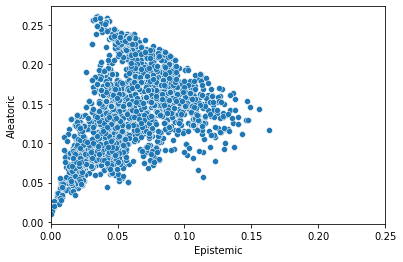

In [72]:
uncertainties['Missclassification']=np.absolute(preds_class-np.array(y_test))
sns.scatterplot(data=uncertainties[uncertainties['Missclassification']==1], x="Epistemic", y="Aleatoric")
plt.xlim(0, 0.25)
plt.savefig('Pictures/uncertainties_scatter_msc.png')

In [28]:
total_mean_msc, ep_mean_msc, al_mean_msc, msc = uncertainties[uncertainties['Missclassification']==1].mean()
print('Uncertainty Mean Values')
print(f'Total Uncertainty {total_mean_msc}')
print(f'Epistemischer Anteil {ep_mean_msc/total_mean_msc}')
print(f'Aleatorischer Anteil {al_mean_msc/total_mean_msc}')

Uncertainty Mean Values
Total Uncertainty 0.20322325702110053
Epistemischer Anteil 0.3455583513787742
Aleatorischer Anteil 0.6544416486212183


# Individual Prediction

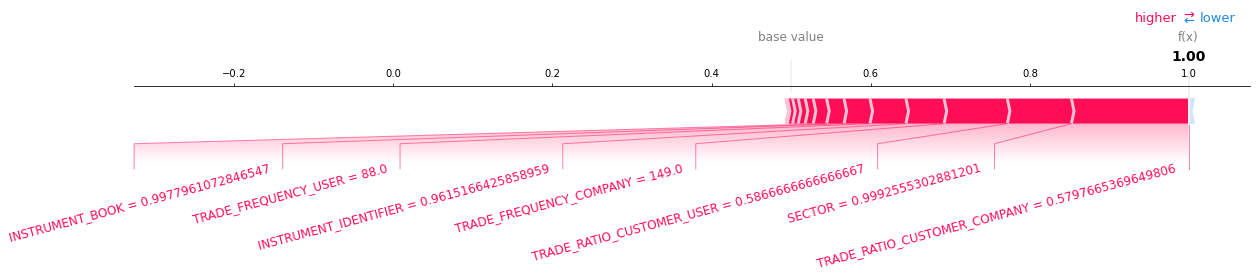

In [218]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train_encoded)

S = x_train_encoded.sample(1)
shap_values_Model = explainer.shap_values(S)
shap.force_plot(explainer.expected_value[1], shap_values_Model[1], S,text_rotation=15, matplotlib=True)

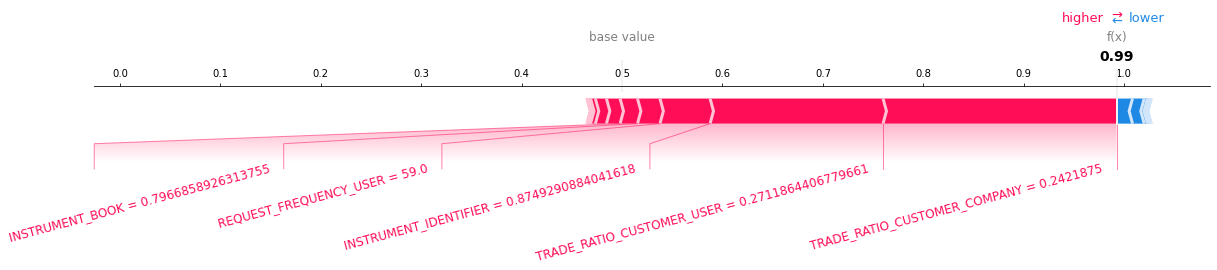

In [108]:
shap.force_plot(explainer.expected_value[1], shap_values_Model[1], S,text_rotation=15, matplotlib=True, show=False)
plt.savefig('Pictures/shap_individual.png')

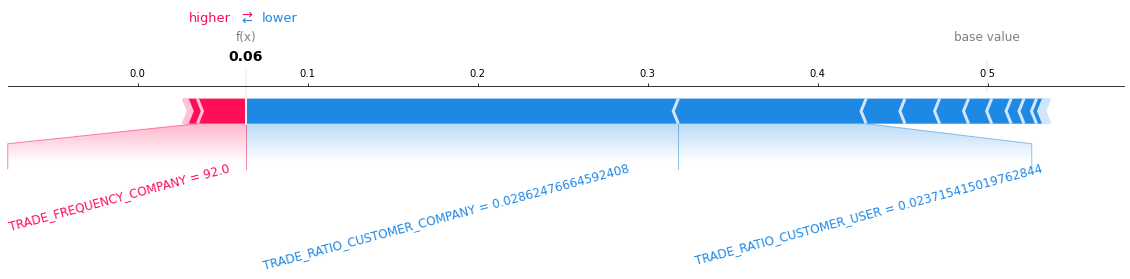

In [199]:
S = x_train_encoded.sample(1)
shap_values_Model = explainer.shap_values(S)
shap.force_plot(explainer.expected_value[1], shap_values_Model[1], S,text_rotation=15, matplotlib=True)

# Global Interpratation

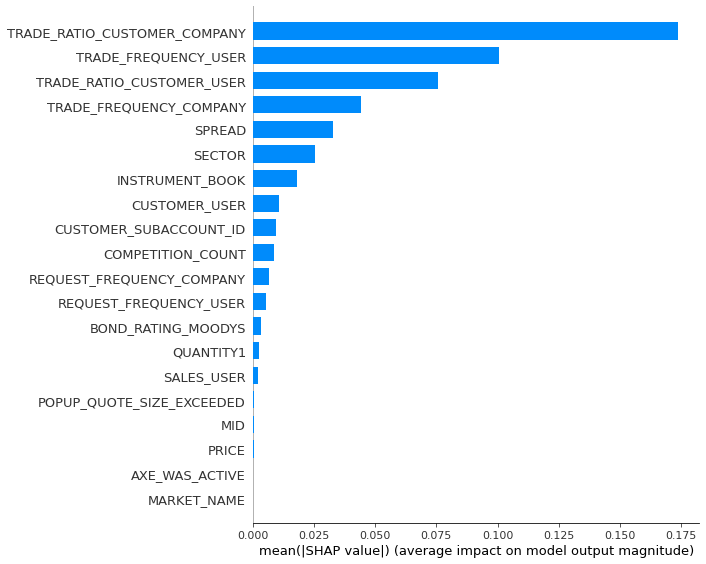

<Figure size 432x288 with 0 Axes>

In [99]:
# feature importance
shap.summary_plot(shap_values[1], x_train_encoded, plot_type="bar")
plt.savefig('Pictures/shap_importance.png')

In [84]:
shap.initjs()
S = x_train_encoded.sample(1000)
shap_values = explainer.shap_values(S)
shap.force_plot(explainer.expected_value[1], shap_values[1], S)

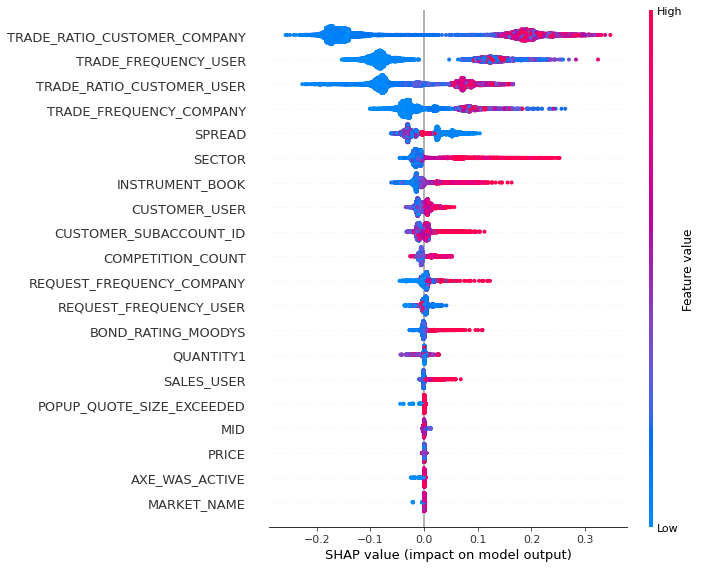

In [101]:
S = x_train_encoded.sample(10000)
shap_values = explainer.shap_values(S)
shap.summary_plot(shap_values[1], S, show=False)
plt.savefig('Pictures/shap_global.png',bbox_inches='tight')

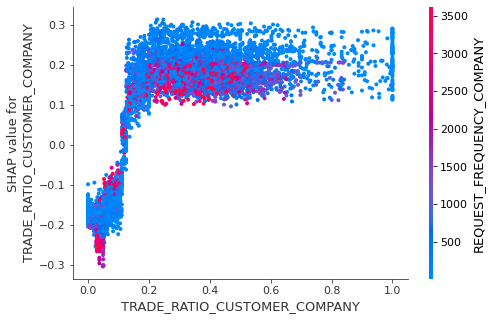

In [63]:
shap.dependence_plot('TRADE_RATIO_CUSTOMER_COMPANY', shap_values[1], S)

# Kommunikation mit Anwendern

In [20]:
print('Min and Max Total Uncertainty')
print(uncertainties['Total'].min())
print(uncertainties['Total'].max())

Min and Max Total Uncertainty
0.001153277449762081
0.3010299216134912


In [38]:
def calculate_caps(uncertainties):
    caps = []
    for i in range(1,3):
        caps.append(np.percentile(uncertainties['Total'], 33.3*i))
    return caps

def print_uncertainty(caps, uncertainty):
    if (uncertainty < caps[0]):
        print (f'{uncertainty}: green')
    elif (uncertainty < caps[1]):
        print (f'{uncertainty}: yellow')
    else: 
        print (f'{uncertainty}: red')

In [39]:
caps = calculate_caps(uncertainties)
for u in uncertainties['Total'].iloc[0:5]:
    print_uncertainty(caps, u)

0.003855540446850236: green
0.2792724025883957: red
0.27233531323588156: red
0.005223804148487: green
0.18166278503106995: yellow


In [41]:
S = x_train_encoded.sample(1000)
shap_values = explainer.shap_values(S)

In [44]:
shap_values[0][1]

array([ 8.72242755e-03,  4.42230839e-02, -3.10802269e-04,  1.54904780e-04,
        4.49990513e-04,  3.28128633e-02,  2.10750982e-03, -1.99730059e-04,
       -1.83360784e-05, -7.88572160e-07,  0.00000000e+00,  3.89293983e-03,
        0.00000000e+00,  2.09254028e-03,  1.81179258e-02, -4.60994688e-05,
        0.00000000e+00, -4.67856525e-05,  0.00000000e+00, -4.03816864e-03,
       -4.49737594e-07,  5.41050881e-02,  7.46908327e-02, -1.82998687e-01,
        3.91065496e-02,  5.25016286e-02, -7.50400961e-02])